In [50]:
import numpy as np
import math
from astropy.io import ascii
import matplotlib.pyplot as plt

In [74]:

#thegaussian model

def gaussianfunc(x, mu, alpha_d, A):
    eq1 = (A/alpha_d)*(np.sqrt(np.log(2)/np.pi))*np.exp((-np.log(2)*((x-mu)**2))/(alpha_d**2))
    return eq1

def log_likelihood(params, x, y, sigma):
    mu, alpha_d, A = params
    G = gaussianfunc(x, mu, alpha_d, A)
    return -0.5 * np.sum((y - G)**2 / sigma**2)

def norm_pdf(x, mean, std):
    return np.log(1/(std*np.sqrt(2*np.pi))) - ((x-mean)**2)/(2*std**2)

def log_prior(params, mu0, sigma_mu, alpha_d0, sigmaAlphad, A0, sigma_a):
    mu, alpha_d, A = params
    lp = norm_pdf(mu, mu0, sigma_mu)
    lp += norm_pdf(alpha_d, alpha_d0, sigmaAlphad)
    lp += norm_pdf(A, A0, sigma_a)
    return lp

def log_posterior(params,x,y,yerror, mu0, sigma_mu, alpha_d0,sigmaAlphad,A0,sigma_a):
    Z = log_likelihood(params, x, y, yerror)
    J = log_prior(params, mu0, sigma_mu, alpha_d0, sigmaAlphad, A0, sigma_a)
    lp = Z+J
    return lp


In [75]:
#data stuff

data = ascii.read('midterm.dat')
nu = data['col1']
phi = data['col2']
err = data ['col3']

In [119]:
#Parameters

A0 = 2.0
mu0 = 46.0
sigma_a = 1.0
sigma_mu = 1.0
alpha_d0 = 12.0
sigmaAlphad = 1.0
numParams = 3
numWalkers = 128
numSteps = 10000
burning = 100
"""
initialparams = np.array([mu0, alpha_d0, A0])
walkerparams = np.random.normal(loc = initialparams, scale = 0.1, size = (numWalkers,numParams))
sampler = np.zeros((numWalkers, (numSteps-burning),numParams))
#mcmc
for i in range(numSteps):
    for j in range(numWalkers):
        proposed = np.random.normal(loc = walkerparams[j], scale = 0.1, size = numParams)
        A = log_posterior(proposed, nu, phi, err, mu0, sigma_mu, alpha_d0, sigmaAlphad, A0,sigma_a) 
        B = log_posterior(walkerparams[j], nu, phi, err, mu0, sigma_mu, alpha_d0, sigmaAlphad, A0, sigma_a)
        log_alpha = A-B
        alpha = min(1.0, np.exp(log_alpha))
        # Accept or reject the proposed parameter set
        if np.random.rand() < alpha:
            walkerparams[j] = proposed
        # Save the parameter values to the sampler
        sampler[j, i-burning, :] = walkerparams[j]
"""
initialparams = np.array([mu0, alpha_d0, A0])
walkerparams = np.random.normal(loc=initialparams, scale=0.1, size=(numWalkers,numParams))
sampler = np.zeros((numWalkers, (numSteps-burning), numParams))

# MCMC
for i in range(numSteps):
    for j in range(numWalkers):
        proposed = np.random.normal(loc=walkerparams[j], scale=0.1, size=numParams)
        A = log_posterior(proposed, nu, phi, err, mu0, sigma_mu, alpha_d0, sigmaAlphad, A0, sigma_a) 
        B = log_posterior(walkerparams[j], nu, phi, err, mu0, sigma_mu, alpha_d0, sigmaAlphad, A0, sigma_a)
        log_alpha = 0.1 * (A - B)
        alpha = min(1.0, np.exp(log_alpha))
        
        # Accept or reject the proposed parameter set
        if np.random.rand() < alpha:
            walkerparams[j] = proposed
            
        # Save the parameter values to the sampler
        sampler[j, i-burning, :] = walkerparams[j]
       

/var/folders/dp/14_5b22171nc4l3vwtn3dyv40000gn/T/ipykernel_45441/3881045083.py:42: RuntimeWarning: overflow encountered in exp
  alpha = min(1.0, np.exp(log_alpha))


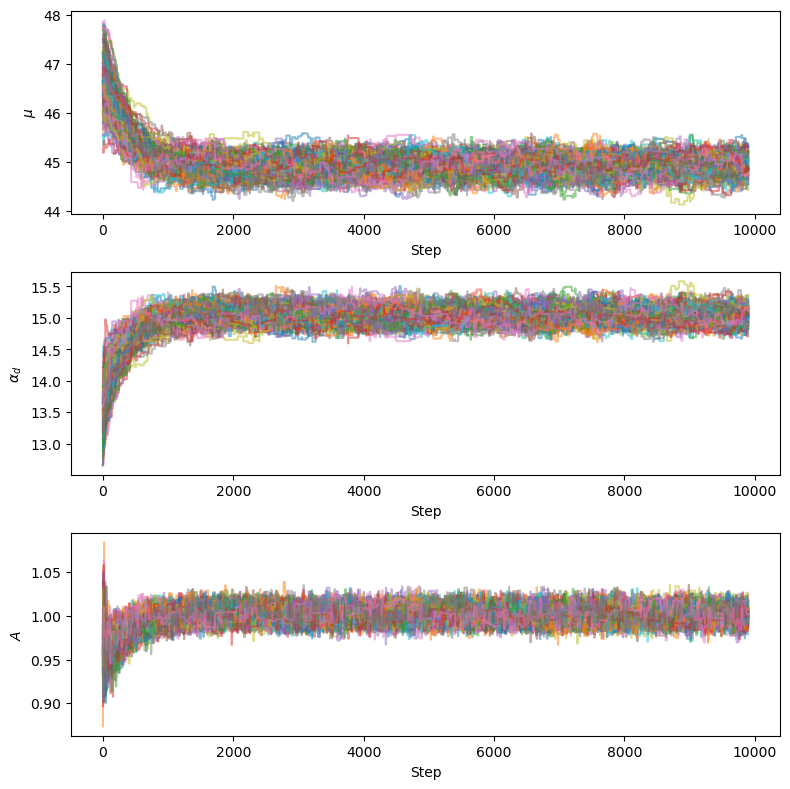

In [120]:
fig, axes = plt.subplots(nrows=numParams, ncols=1, figsize=(8, 8))
for i in range(numParams):
    for j in range(numWalkers):
        axes[i].plot(sampler[j, :, i], alpha=0.5)
    axes[i].set_xlabel('Step')
axes[0].set_ylabel("$\mu$")
axes[1].set_ylabel(r"$\alpha_{d}$")
axes[2].set_ylabel("$A$")
plt.tight_layout()
plt.show()

In [121]:
#make the sampler into a 2d array and flatten

sample_flat_2d = sampler[:, burning:, :].reshape((-1, numParams))

#median
median = np.median(sample_flat_2d, axis = 0)
lower = np.percentile(sample_flat_2d, 16, axis = 0)
upper = np.percentile(sample_flat_2d,84,axis=0)

print('Best-fit parameters:')
print(f"mu:      {median[0]:.2f} +{upper[0]-median[0]:.2f}/-{median[0]-lower[0]:.2f}")
print(f"alpha_D: {median[1]:.2f} +{upper[1]-median[1]:.2f}/-{median[1]-lower[1]:.2f}")
print(f"A:       {median[2]:.2f} +{upper[2]-median[2]:.2f}/-{median[2]-lower[2]:.2f}")

Best-fit parameters:
mu:      44.94 +0.23/-0.21
alpha_D: 15.03 +0.14/-0.15
A:       1.00 +0.01/-0.01


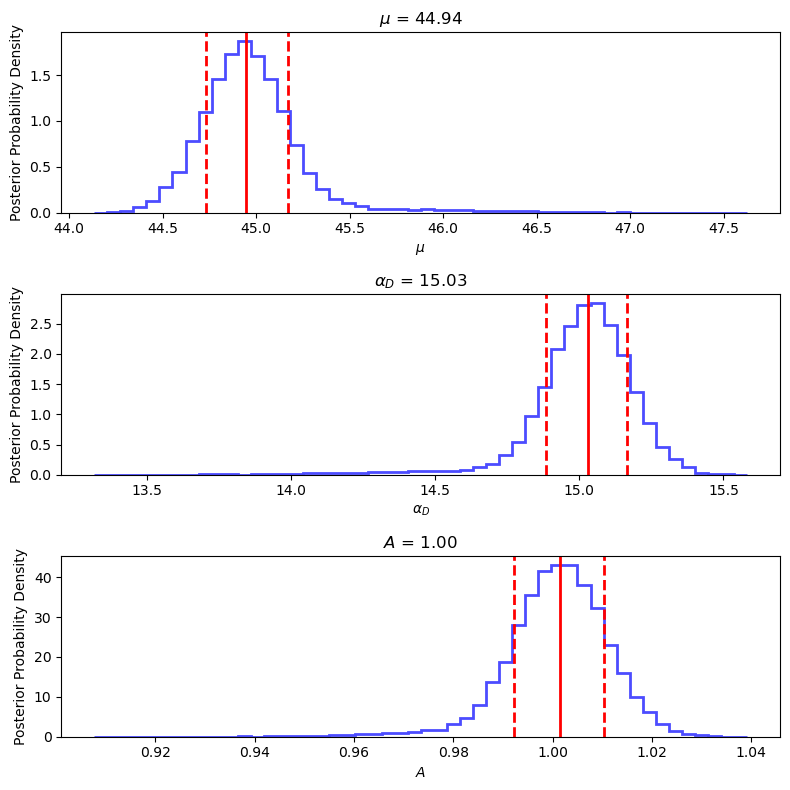

In [122]:
fig, axes = plt.subplots(nrows=numParams, ncols=1, figsize=(8, 8))
for i in range(numParams):
    ax = axes[i]
    ax.hist(sample_flat_2d[:, i], bins=50, density=True, histtype='step', color='blue', lw=2, alpha=0.7)
    ax.axvline(median[i], color='red', linestyle='-', lw=2)
    ax.axvline(lower[i], color='red', linestyle='--', lw=2)
    ax.axvline(upper[i], color='red', linestyle='--', lw=2)
    ax.set_ylabel('Posterior Probability Density')

axes[0].set_xlabel("$\mu$")
axes[0].set_title('$\mu$ = {:.2f}'.format(median[0]))
axes[1].set_xlabel(r"$\alpha_{D}$")
axes[1].set_title(r"$\alpha_D$ = {:.2f}".format(median[1]))
axes[2].set_xlabel("$A$")
axes[2].set_title("$A$ = {:.2f}".format(median[2]))

plt.tight_layout()
plt.show()

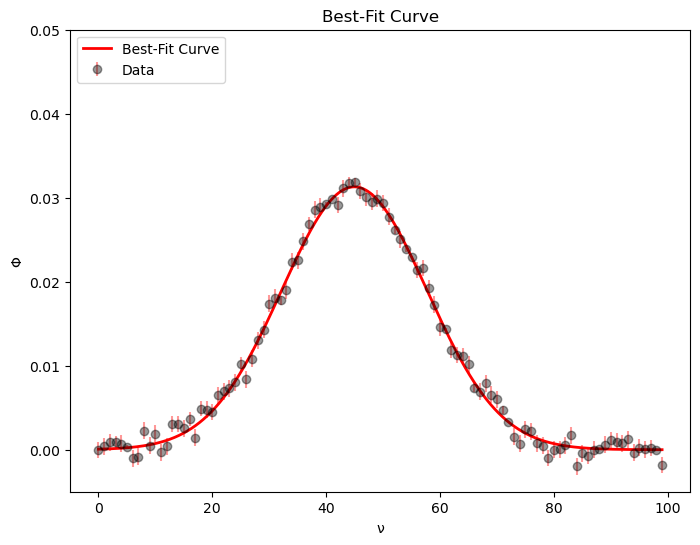

In [123]:
xfit = np.linspace(nu.min(), nu.max(), 1000)
yfit = gaussianfunc(xfit, median[0], median[1], median[2])

# Plot the best-fit curve and the data
fig, ax = plt.subplots(figsize=(8, 6))
plt.errorbar(nu, phi, yerr=err, fmt='o', alpha=0.4, color='black', ecolor='red', label='Data')
ax.plot(xfit, yfit, color='red', lw=2, label='Best-Fit Curve')
ax.legend(loc='upper left')
ax.set_xlabel('\u03BD')
ax.set_ylabel('\u03A6')
ax.set_title('Best-Fit Curve')
plt.ylim(-0.005, 0.05)
plt.show()